In [ ]:
!nvidia-smi

In [1]:
import os
import tqdm
import h5py
import json
import copy
import random
import tifffile
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [21]:
def loadJson(file_name):
    '''简易加载json'''
    with open(file_name,'r') as f:
        js = json.load(f)
    return js

def saveJson(file, file_name):
    '''简易保存json'''
    with open(file_name,'w') as f:
        json.dump(file,f)

In [24]:
def to_uint8(im, stretch=False):
    from skimage import exposure
    import numpy as np
    # 2% linear stretch
    def _two_percent_linear(image, max_out=65535, min_out=0):
        def _gray_process(gray, maxout=max_out, minout=min_out):
            # Get the corresponding gray level at 98% in the histogram.
            high_value = np.percentile(gray, 98)
            low_value = np.percentile(gray, 2)
            truncated_gray = np.clip(gray, a_min=low_value, a_max=high_value)
            processed_gray = ((truncated_gray - low_value) / (high_value - low_value)) * (maxout - minout)
            return np.uint16(processed_gray)

        if len(image.shape) == 3:
            processes = []
            for b in range(image.shape[-1]):
                processes.append(_gray_process(image[:, :, b]))
            result = np.stack(processes, axis=2)
        else:  # if len(image.shape) == 2
            result = _gray_process(image)
        return np.uint16(result)

    # Simple image standardization
    def _sample_norm(image):
        stretches = []
        if len(image.shape) == 3:
            for b in range(image.shape[-1]):
                stretched = exposure.equalize_hist(image[:, :, b])
                stretched /= float(np.max(stretched))
                stretches.append(stretched)
            stretched_img = np.stack(stretches, axis=2)
        else:  # if len(image.shape) == 2
            stretched_img = exposure.equalize_hist(image)
        return np.uint16(stretched_img * 65535)

    dtype = im.dtype.name
    if dtype != "uint16":
        im = _sample_norm(im)
    if stretch:
        im = _two_percent_linear(im)
    return im

In [25]:
def imgPreProcess_twoPercent(path_img, debug=False):
    image = tifffile.imread(path_img)
    if image.shape[-1] != 125:
        image = image.transpose(1,2,0)
    if debug:
        image = to_uint16(image[:,:,[55,28,7]], True)
    else:
        image = to_uint16(image, True)
    return image

def imgPreProcess_simpleClip(path_img, debug=False):
    image = tifffile.imread(path_img)
    if image.shape[-1] != 125:
        image = image.transpose(1,2,0)
    if debug:
        image = np.clip(image[:,:,[55,28,7]], 0, 10000)
    else:
        image = np.clip(image, 0, 10000)
    return image

In [26]:
def cropAndAnno(points, shift_r, shift_c, img_ori, crop_size, anno):
    '''根据一个框的左上点，做一些偏移，剪裁完在该图上标注'''
    (c_min,r_min),(c_max,r_max) = points
    c_min = int(c_min)
    r_min = int(r_min)
    c_max = int(c_max)
    r_max = int(r_max)
    r, c = r_min + shift_r, c_min + shift_c
    img_crop = img_ori[r:r+crop_size,c:c+crop_size,:].copy()
    shapes,labels_categories,labels_numrical = getNewBox(r, c, crop_size, anno)
    return img_crop, shapes, labels_categories, labels_numrical

In [27]:
def getNewBox(r,c,crop_size,anno):
    shapes_crop = []
    labels_crop_categories = []
    labels_crop_numrical = []
    anno = copy.deepcopy(anno)
    for shape in anno['shapes']:
        (c_min,r_min),(c_max,r_max) = shape['points']
        
        r_min,r_max = (r_min,r_max) if r_max >= r_min else (r_max,r_min)
        c_min,c_max = (c_min,c_max) if c_max >= c_min else (c_max,c_min)
        
        c_min = int(c_min)
        r_min = int(r_min)
        c_max = int(c_max)
        r_max = int(r_max)
        
        flag_c_min = c<=c_min<c+crop_size-1
        flag_c_max = c+1<=c_max<c+crop_size
        flag_r_min = r<=r_min<r+crop_size-1
        flag_r_max = r+1<=r_max<r+crop_size
        
        c_min = c_min - c if flag_c_min else 0
        r_min = r_min - r if flag_r_min else 0
        c_max = c_max - c if flag_c_max else crop_size-1
        r_max = r_max - r if flag_r_max else crop_size-1
        
        if c_max - c_min == crop_size-1:
            continue
        if r_max - r_min == crop_size-1:
            continue
        if (abs(c_max-c_min) < 10) or (abs(c_max-c_min) < 10):
            continue
        if not (0.4 <= (c_max - c_min)/(r_max - r_min) <= 2.5):
            continue
        shapes_crop.append([c_min,r_min,c_max,r_max])
        label = float(shape['label'][:-1])
        labels_crop_numrical.append(label)
        labels_crop_categories.append(1)
    return shapes_crop, np.array(labels_crop_categories),np.array(labels_crop_numrical)

In [28]:
def saveHdf(data, saveRoot, fn, phase):
    prefix = os.path.join(saveRoot, phase)
    if not os.path.exists(prefix):
        os.makedirs(prefix)
    fn = os.path.join(prefix, fn)
    with h5py.File(fn,'w') as f:
        f['image'] = data

In [29]:
path_dict = {
             '/data/run01/scw6493/data/imgs/ori_img_20220520.tif':'/data/run01/scw6493/data/label/final_20220520.json',
             '/data/run01/scw6493/data/imgs/ori_img_20220615.tif':'/data/run01/scw6493/data/label/final_20220615.json',
             '/data/run01/scw6493/data/imgs/ori_img_20211114.tif':'/data/run01/scw6493/data/label/final_20211114.json',
             '/data/run01/scw6493/data/imgs/ori_img_20211125.tif':'/data/run01/scw6493/data/label/final_20211124.json',
             '/data/run01/scw6493/data/imgs/ori_img_20211221.tif':'/data/run01/scw6493/data/label/final_20211221.json',
            }

In [30]:
crop_size = 512
saveRoot = f'/data/run01/scw6493/data/anno/coco_{crop_size}'
result = {'train':{'images':[],'annotations':[],'categories':[{'id': 1,'name':'SichuanPepper'}]},
          'valid':{'images':[],'annotations':[],'categories':[{'id': 1,'name':'SichuanPepper'}]},
          'test': {'images':[],'annotations':[],'categories':[{'id': 1,'name':'SichuanPepper'}]}}
for k,v in path_dict.items():
    print(k)
    image = imgPreProcess_simpleClip(k)
    anno = loadJson(v)
    for shape in tqdm.tqdm(anno['shapes']):
        phase = 'train'
        (c_min,r_min),(c_max,r_max) = shape['points']
        if (2000<c_min<3000) and (2000<r_min<3000):
#             rnd = random.random()
#             if rnd < 0.5:
#                 phase = 'valid'
            if c_min > 2500:
                phase = 'valid'
            else:
                phase = 'test'
        for shift_r,shift_c in [(128,128),(128,-128),(-128,128),(-128,-128)]:
            # 50%概率跳过
            if random.random() < 0.5 : continue
            lenght_id = len(result[phase]['images']) + 1
            fn_hdf = f'{lenght_id:04d}.hdf'
            # 裁剪选定区域
            img_crop, shapes, labels_categories, labels_numrical = cropAndAnno(shape['points'], shift_r, shift_c,image,crop_size,anno)
            # 先尝试保存
            try:
#                 pass
                saveHdf(img_crop,saveRoot,fn_hdf,phase)
            except:
                continue
            # 转格式
            anno_image = {'file_name':fn_hdf,'height':crop_size,'width':crop_size,'id':lenght_id}
            result[phase]['images'].append(anno_image)
            for box, label, num in zip(shapes, labels_categories, labels_numrical):
                anno_tem = {'segmentation':[],'area':None,'iscrowd': 0,
                            'image_id':len(result[phase]['images']),
                            'bbox': None,
                            'category_id':None,
                            'numrical_label':None,
                            'id': None}
                c_min,r_min,c_max,r_max = box
                anno_tem['bbox'] = [c_min,r_min,c_max-c_min,r_max-r_min]
                anno_tem['area'] = (c_max-c_min)*(r_max-r_min)
                anno_tem['category_id'] = label.item()
                anno_tem['numrical_label'] = num
                anno_tem['id'] = len(result[phase]['annotations'])
#                 print(len(result[phase]['annotations']))
                result[phase]['annotations'].append(anno_tem)

saveJson(result['train'],os.path.join(saveRoot,'train.json'))
saveJson(result['valid'],os.path.join(saveRoot,'valid.json'))
saveJson(result['test' ],os.path.join(saveRoot,'test.json' ))

/data/run01/scw6493/data/imgs/ori_img_20220520.tif


100%|██████████| 540/540 [08:56<00:00,  1.01it/s]


/data/run01/scw6493/data/imgs/ori_img_20220615.tif


100%|██████████| 279/279 [02:55<00:00,  1.59it/s]


/data/run01/scw6493/data/imgs/ori_img_20211114.tif


100%|██████████| 276/276 [03:08<00:00,  1.47it/s]


/data/run01/scw6493/data/imgs/ori_img_20211125.tif


TiffTag 34737: coercing invalid ASCII to bytes
100%|██████████| 287/287 [02:57<00:00,  1.62it/s]


/data/run01/scw6493/data/imgs/ori_img_20211221.tif


100%|██████████| 393/393 [03:49<00:00,  1.71it/s]


In [17]:
# saveJson(result['train'],os.path.join(saveRoot,'train.json'))
# saveJson(result['valid'],os.path.join(saveRoot,'valid.json'))
# saveJson(result['test' ],os.path.join(saveRoot,'test.json' ))

In [6]:
phase = 'train'
saveRoot = f'/data/run01/scw6493/data/anno/coco_512/'
js = loadJson(f'../data/anno/coco_512/{phase}.json')
for i in range(len(js['annotations'])):
    anno = js['annotations'][i]
    image_id = anno['image_id']
    c,r,w,h = anno['bbox']
    if anno['area']<100: print(anno)
#     if c * r <= 0: print(anno)

{'segmentation': [], 'area': 72, 'iscrowd': 0, 'image_id': 7, 'bbox': [505, 499, 6, 12], 'category_id': 1, 'numrical_label': 0.01, 'id': 211}
{'segmentation': [], 'area': 10, 'iscrowd': 0, 'image_id': 54, 'bbox': [0, 509, 5, 2], 'category_id': 1, 'numrical_label': 0.03, 'id': 1499}
{'segmentation': [], 'area': 8, 'iscrowd': 0, 'image_id': 61, 'bbox': [509, 507, 2, 4], 'category_id': 1, 'numrical_label': 0.01, 'id': 1696}
{'segmentation': [], 'area': 30, 'iscrowd': 0, 'image_id': 67, 'bbox': [0, 505, 5, 6], 'category_id': 1, 'numrical_label': 0.04, 'id': 1993}
{'segmentation': [], 'area': 60, 'iscrowd': 0, 'image_id': 71, 'bbox': [0, 501, 6, 10], 'category_id': 1, 'numrical_label': 0.02, 'id': 2167}
{'segmentation': [], 'area': 28, 'iscrowd': 0, 'image_id': 117, 'bbox': [0, 504, 4, 7], 'category_id': 1, 'numrical_label': 0.04, 'id': 3971}
{'segmentation': [], 'area': 36, 'iscrowd': 0, 'image_id': 183, 'bbox': [0, 502, 4, 9], 'category_id': 1, 'numrical_label': 0.05, 'id': 6273}
{'segmen

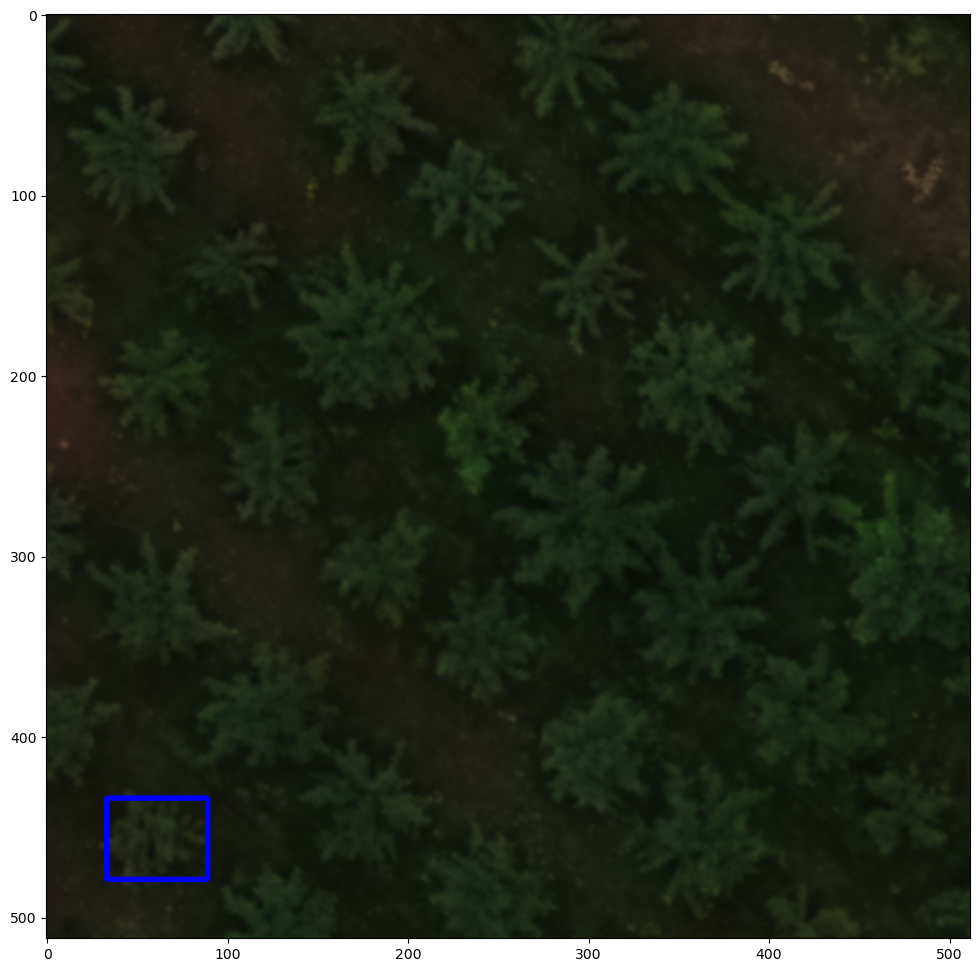

In [34]:
phase = 'test'
saveRoot = f'/data/run01/scw6493/data/anno/coco_512/'
js = loadJson(f'../data/anno/coco_512/{phase}.json')
i = 125
anno = js['annotations'][i]
image_id = anno['image_id']
c,r,w,h = anno['bbox']
numrical_label = anno['numrical_label']
cat_label = anno['category_id']
image_name = [d['file_name'] for d in js['images'] if d['id'] == image_id][0]
with h5py.File(os.path.join(saveRoot,phase,image_name),'r') as f:
    image = f['image'][:]
    
img_show = (image[:,:,[55,28,7]]).copy()
img_show = np.uint8(img_show/8000*255)
img_show = cv.rectangle(img=img_show,
                        pt1=(c,r),
                        pt2=(c+w,r+h),
                        color =(0,0,255),
                        thickness=2)

plt.figure(0,(12,12))
plt.imshow(img_show)
plt.show()

In [10]:
path_img = '../data/imgs/ori_img_20211125.tif'
image = imgPreProcess_simpleClip(path_img, True)
image.shape

TiffTag 34737: coercing invalid ASCII to bytes


(3274, 2652, 3)

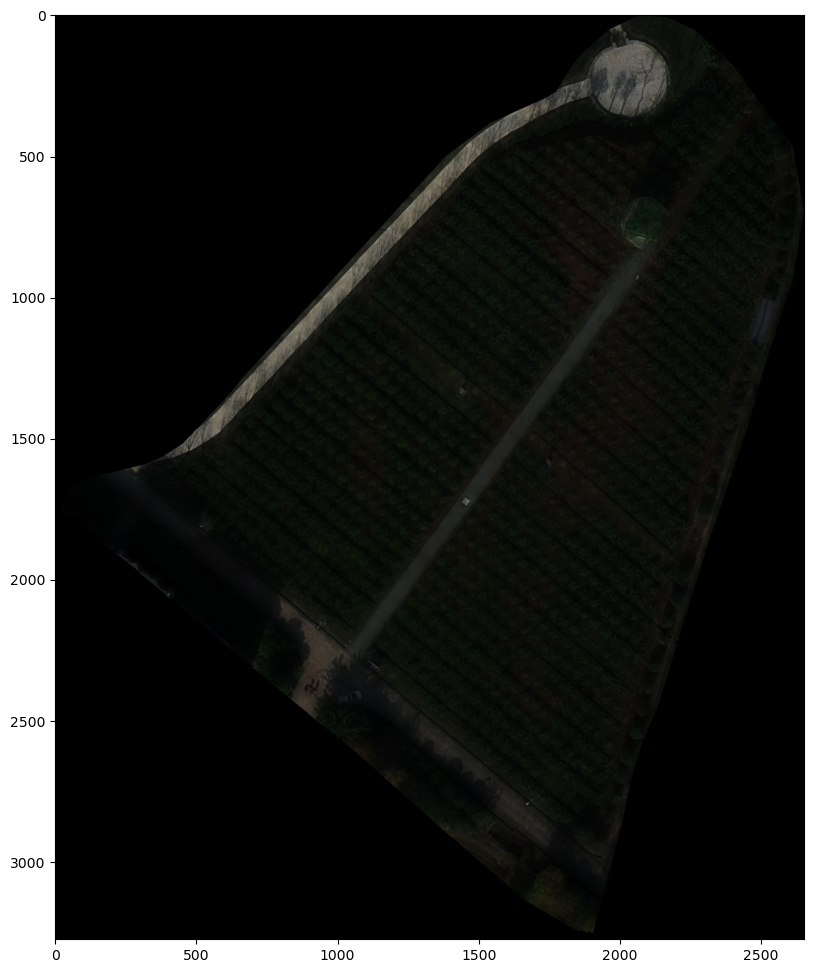

In [11]:
img_show = image.copy()
plt.figure(0,(12,12))
plt.imshow(np.uint8(img_show/10000*255))
plt.show()

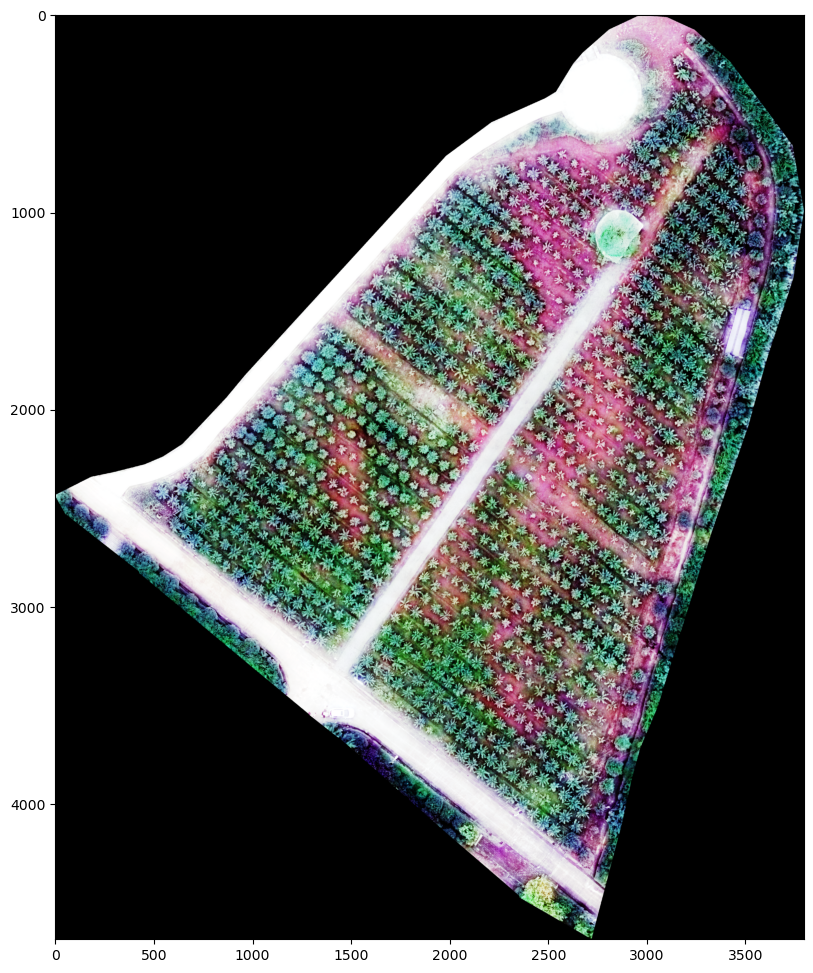

In [11]:
img_show = image.copy()
plt.figure(0,(12,12))
plt.imshow(img_show)
plt.show()

In [14]:
path_img = '../data/imgs/ori_img_20220520.tif'
image = tifffile.imread(path_img)
if image.shape[-1] != 125:
    image = image.transpose(1,2,0)

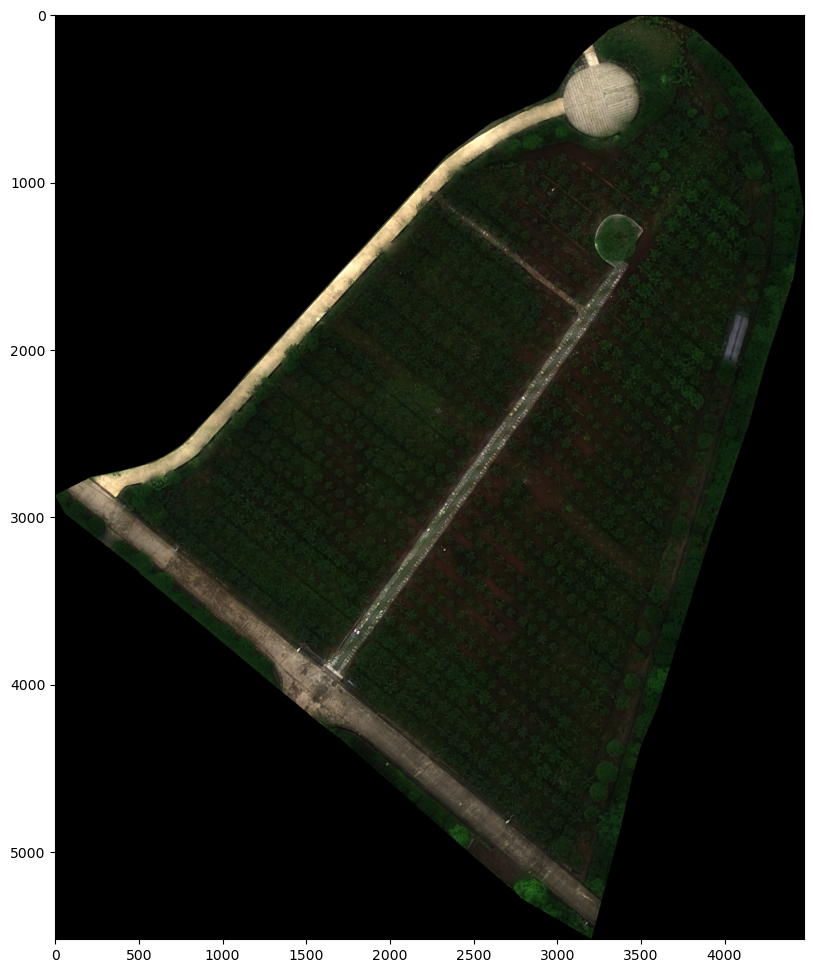

In [15]:
img_show = (np.clip(image[:,:,[55,28,7]]/10000,0,1)*255).astype(np.uint8).copy()
plt.figure(0,(12,12))
plt.imshow(img_show)
plt.show()